# Example for the Audio Encoder model

This notebook will show the core power of `encoder networks` : the ability to generalize to unseen labels !

The idea is the following : 
1. Split the `common_voice` + `voxforge` datasets (or `LibriSpeech`) in 2 subsets where **all** speakers are different (i.e. no speaker from valid set is in the train set and vice-versa)
2. Create grouper dataset format for both : this kind of dataset creates *groups* of `n_utterance` data belonging to the same speake (i.e. if `n_utterance = 4`, `generator[0:4]` are from speaker 1, `generator[4:8]` from speaker 2 etc.).
3. Preload a large amount of audios : grouper datasets work with random groups so the same audio may appear in multiple groups. To avoid reloading multiple times the same data, we cache them ! It is the reason why I am using an `AudioGrouperGenerator` as dataset (it also works without but it is much slower). Note that this operation is memory-intensive so make sure to adapt `cache_size` according to your **CPU** memory (50k is a good choice for 32Go RAM). 
4. Train the model on the `train_set` and evaluate it on `valid_set`. Reminder : **all** validation metrics will be on **new labels**
5. Make funny plots !

Performance note : when caching 100% of the dataset, I achieve less than 400ms/batch performance while a 2s/batch when loading a smaller part and far more if not using the generator.

*Raw Audio* vs *Mel spectrogram* input : both are performant (maybe raw audio is slighly better) but it seems that `mel-based` models are better to usefor the `SV2TTS` architecture (cf https://github.com/yui-mhcp/text_to_speech project). 

Note : this notebook is an adapted copy of `example_audio_siamese` so it is possible that some parts have not been fully adapted ;) Furthermore, some features available in `siamese networks` are not implemented in the `encoder networks` yet but will be in the next update !

## Imports + model initialization

In [1]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
from sklearn.utils import shuffle as sklearn_shuffle

from models import get_pretrained
from models.siamese import AudioEncoder
from custom_train_objects import AudioGrouperGenerator
from utils import plot, plot_multiple, plot_embedding, plot_confusion_matrix, set_display_options, sample_df
from datasets import get_dataset, prepare_dataset, train_test_split, test_dataset_time

set_display_options()

model_name = 'audio_encoder_256_mel_lstm'

print("Tensorflow version : {}".format(tf.__version__))
print('Available GPU(s) : {}'.format(tf.config.list_physical_devices('GPU')))

Tensorflow version : 2.10.0
Available GPU(s) : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
input_type = model_name.split('_')[-2]
config = {
    'distance_metric' : 'euclidian',
    'input_type'    : input_type,
    'audio_rate'    : 22050,
    'use_fixed_length_input' : False,
    'embedding_dim' : int(model_name.split('_')[-3]),

    'normalize' : True,
    'max_audio_time' : 3,
    'flatten_type' : 'lstm',
    'final_activation' : 'relu'
}

model = AudioEncoder(nom = model_name, ** config)

print(model)
#model.encoder.summary()

Set `use_mask = True` by default as the masking operation is supported. To remove this message or change the behavior, explicitely pass `use_mask = ...`
Initializing model with kwargs : {'model': <keras.engine.sequential.Sequential object at 0x000001AAD8122BC0>}
Initializing submodel : `model` !
Submodel model saved in pretrained_models\audio_encoder_256_mel_lstm\saving\model.json !
Model audio_encoder_256_mel_lstm initialized successfully !

========== audio_encoder_256_mel_lstm ==========
Sub model model
- Inputs 	: (None, None, 80)
- Outputs 	: (None, 256)
- Number of layers 	: 28
- Number of parameters 	: 2.669 Millions
- Model not compiled

Already trained on 0 epochs (0 steps)

- Embedding dim : 256
- Distance metric : euclidian
- Audio rate : 22050
- # mel channels : 80



**Important note** : in the below cell you can observe some custom layers *Masked...*. These layers are subclasses of their associated layer but with masking support, meaning that if some parts of the input sequence is masked by the `Masking` layer, they will use and propagate the mask (which is currently not supported in regular `Conv1D`).

The `MaskedZeroPadding1D` is there to make a `padding = 'same'` behavior in a *manual* way (you can disable it by setting the config `use_manual_padding = False`). I have noticed that, `padding = 'same'` in `Conv1D` does not give the same result as if you manually zero-pads the input which differs from the `torch` behavior (and thus can cause issue when converting models). Furthermore, when `batch_size > 1`, the padding is not put at the same place as if no batching was applied (and then no data-padding) (which is consitant with the way padding works) but it therefore gives different results with and without batching. The `MaskedZeroPadding1D` solves this issue and now you can batch your sequential data without any issue ! :)

If you want more information about this phenomenon and the way I solved it, you can contact me or read the my code ;)

In [3]:
model.summary()


========== Summary of model ==========

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 80)          0         
                                                                 
 masked_zero_padding1d (Mask  (None, None, 80)         0         
 edZeroPadding1D)                                                
                                                                 
 conv_1 (MaskedConv1D)       (None, None, 128)         71808     
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 128)         0         
                                                                 
 dropout (Dropout)

## Model instanciation + dataset loading

The `RMSProp` optimizer seems to give faster result than `Adam` but no rigorous comparison. 

In [2]:
model = get_pretrained(model_name)

model.compile(
    optimizer = 'rmsprop', 
    loss_config = {'init_w' : 1 if model.distance_metric in ('dp', 'cosine') else -1},
    optimizer_config = {'lr' : {'name' : 'DivideByStep', 'maxval' : 1e-3,'minval' : 1e-4}}
)
print(model)

Model restoration...
Initializing submodel : `model` !
Successfully restored model from pretrained_models/audio_encoder_256_mel_lstm/saving/model.json !
Model audio_encoder_256_mel_lstm initialized successfully !
Optimizer 'model_optimizer' initilized successfully !
Submodel model compiled !
  Loss : {'reduction': 'none', 'name': 'ge2e_loss', 'mode': 'softmax', 'init_w': -1.0, 'init_b': 0.0, 'distance_metric': 'euclidian'}
  Optimizer : {'name': 'RMSprop', 'learning_rate': {'class_name': 'DivideByStep', 'config': {'factor': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'minval': <tf.Tensor: shape=(), dtype=float32, numpy=1e-04>, 'maxval': <tf.Tensor: shape=(), dtype=float32, numpy=0.001>}}, 'decay': 0.0, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
  Metrics : [{'name': 'ge2e_metric', 'dtype': 'float32', 'mode': 'softmax', 'distance_metric': 'euclidian'}]

========== audio_encoder_256_mel_lstm ==========
Sub model model
- Inputs 	: (None, None, 80)
- Outputs 	: 

## Dataset loading

I left the 3 options for dataset : french only (`CommonVoice + VoxForge`), english only (`LLibriSpeech`) or a mixture of both. You just have to execute one of them for training / testing.


In [3]:
preload     = True
n_utterance = 16
datasets = ['common_voice', 'voxforge']

dataset = get_dataset(datasets)
train, valid = train_test_split(dataset, valid_size = 0.1, split_by_unique = True, min_occurence = n_utterance)

train = AudioGrouperGenerator(
    train, n_utterance = n_utterance, rate = model.audio_rate, mel_fn = model.mel_fn,
    n_round = 10, cache_size = 150000, min_occurence = 0, preload = preload, random_state = 10
)
valid = AudioGrouperGenerator(
    valid, n_utterance = n_utterance, rate = model.audio_rate, mel_fn = model.mel_fn,
    n_round = 5, cache_size = 10000, min_occurence = 0, preload = preload
)

print("Dataset length :\n  Training set : {}\n  Validation set : {}".format(
    len(train), len(valid)
))

Loading dataset common_voice...
Loading dataset voxforge...


100%|██████████████████████████████████████████████████████████████████████████████| 6147/6147 [05:16<00:00, 19.40it/s]

Dataset length :
  Training set : 436192
  Validation set : 27840


In [4]:
print(train, '\n')
print(valid)

print("Number of ids in valid also in train : {}".format(
    sum([valid_id in train.ids for valid_id in valid.ids])
))
print("Number of ids in train also in train (to test) : {}".format(
    sum([train_id in train.ids for train_id in train.ids])
))


AudioGrouper Generator :
- Length : 436192
- Unique ids   : 3129
- Total files  : 436192
- Unique files : 178049 (40.82 %)
- Cache size   : 100000 (loaded : 100.00 %) 

AudioGrouper Generator :
- Length : 27840
- Unique ids   : 348
- Total files  : 27840
- Unique files : 6147 (22.08 %)
- Cache size   : 6147 (loaded : 100.00 %)
Number of ids in valid also in train : 0
Number of ids in train also in train (to test) : 3129


## Training

Note that `cache = False` and `shuffle_size = 0` are recommanded to not waste memory / time as the `generator` already cache the right amount of file (to not overload your memory) and shuffle the whole dataset at every epoch. 

The `GE2EMetric` is a custom metric created based on the `GE2ELoss` : the loss uses either `categorical_crossentropy (mode = 'softmax')` either `binary_crossentropy (mode = 'contrast')` so I simply use the associated metric (`categorical_accuracy` or `EER`) to compute metrics.

In [ ]:
epochs = 25
batch_size = n_utterance ** 2

print("Training samples   : {} - {} batches".format(len(train), len(train) // batch_size))
print("Validation samples : {} - {} batches".format(len(valid), len(valid) // (batch_size * 2)))

hist = model.train(
    train, validation_data = valid, pred_step = -5,
    epochs = epochs, batch_size = batch_size, valid_batch_size = 2.,
    cache = False, shuffle_size = 0, augment_prct = 0.25
)

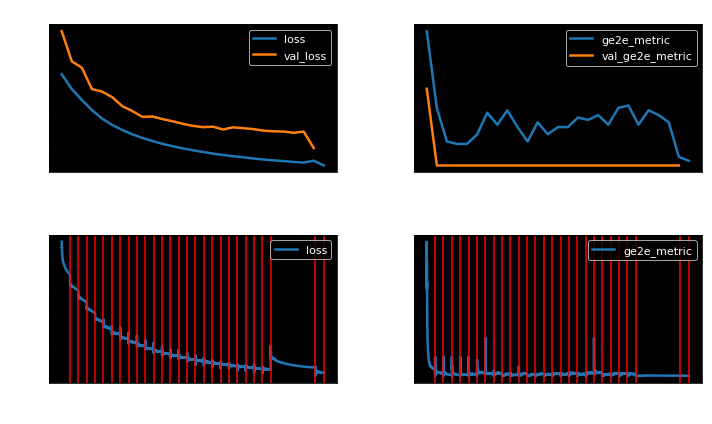

In [3]:
model.plot_history()

## Evaluation

**Important** : this testing was done with an older model and not the one trained above.

Explaination : on the metrics you can see `{test_ / val_ / } metric_name` : 
- The `test_` prefix is for testing (testing outside the training loop)
- The `val_` prefix is for the validation metrics (validation set during training)
- The metric without prefix is for the training metrics

They are all shown in the final print of the `ProgressBar` callback because the `on_epoch_end()` is called with all metrics in `model.history` for this epoch (and then all metrics from training)

During the testing progression, only `test_` metrics are shown

It is a technical reason but important to explain it to avoid confusion ;)

I decided to separate `test_` and `val_` prefix for 2 main reasons : 
1. It allows to separate validation and testing which can be done on different datasets
2. Allow to test on other metrics (other than those used for training / validation) without modifying the validation metrics (not well supported yet)

Indeed, as you use the validation set to fine-tune your model parameters, this set is not *completely* independant from your model / training procedure so testing on completely new datasets can be interesting !

Here I made the testing on `valid` which is *theorically speaking* not a good idea but it is just a demonstration.

A good idea could be to test the model on `LibriSpeech` while training / validating it on `common_voice` and `voxforge`  (or the opposit).

As a side note : you can see the `testing config` contains `augment_prct` but in theory this parameter is **not** used in validation / testing so it is here just because it is a `training hyperparameter` but it is not used here

In [ ]:
h = model.test(valid)

## Embedding

What we can see in this plot : 
- Many color points in a black background : quite beautiful ! :D (points correspond to embedded audio while colors represent speakers)
- We can observe clusters of points which are clearly identified and far away from other clusters
- Some speakers seems to be hard to distinguish (points in the middle-right) : here can be some hypothesis
    - Speakers have similar voices
    - Audios are bad quality (noisy, ...) which can make the representation harder* (especially possible for the 2nd demonstration on `VoxForge`)

Reminder : **all these speakers are totally unknown** ! The model **never** saw them in its training data

*`common_voice` and `voxforge` are datasets suited for `Text-To-Speech` and are not perfect quality audio : there is noise, bad quality recording, voice intensity highly variable, ... 

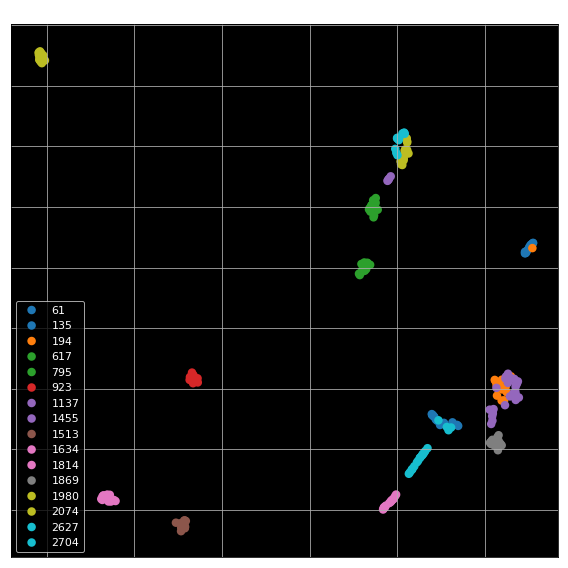

In [7]:
samples = pd.DataFrame([train[i] for i in range(n_utterance ** 2)])

model.plot_embedding(samples)


========== audio_encoder_256_mel_lstm ==========
Sub model model
- Inputs 	: (None, None, 80)
- Outputs 	: (None, 256)
- Number of layers 	: 24
- Number of parameters 	: 3.588 Millions
- Optimizer 	: {'name': 'RMSprop', 'learning_rate': {'class_name': 'DivideByStep', 'config': {'factor': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'minval': <tf.Tensor: shape=(), dtype=float32, numpy=1e-04>, 'maxval': <tf.Tensor: shape=(), dtype=float32, numpy=0.001>}}, 'decay': 0.0, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
- Loss 	 : {'reduction': 'none', 'name': 'ge2e_loss', 'mode': 'softmax', 'init_w': -4.3138237, 'init_b': 0.14260964, 'distance_metric': 'euclidian'}
- Metrics	 : [{'name': 'ge2e_metric', 'dtype': 'float32', 'mode': 'softmax', 'distance_metric': 'euclidian'}]

Already trained on 27 epochs (10033 steps)

- Embedding dim : 256
- Distance metric : euclidian
- Audio rate : 22050
- # mel channels : 80



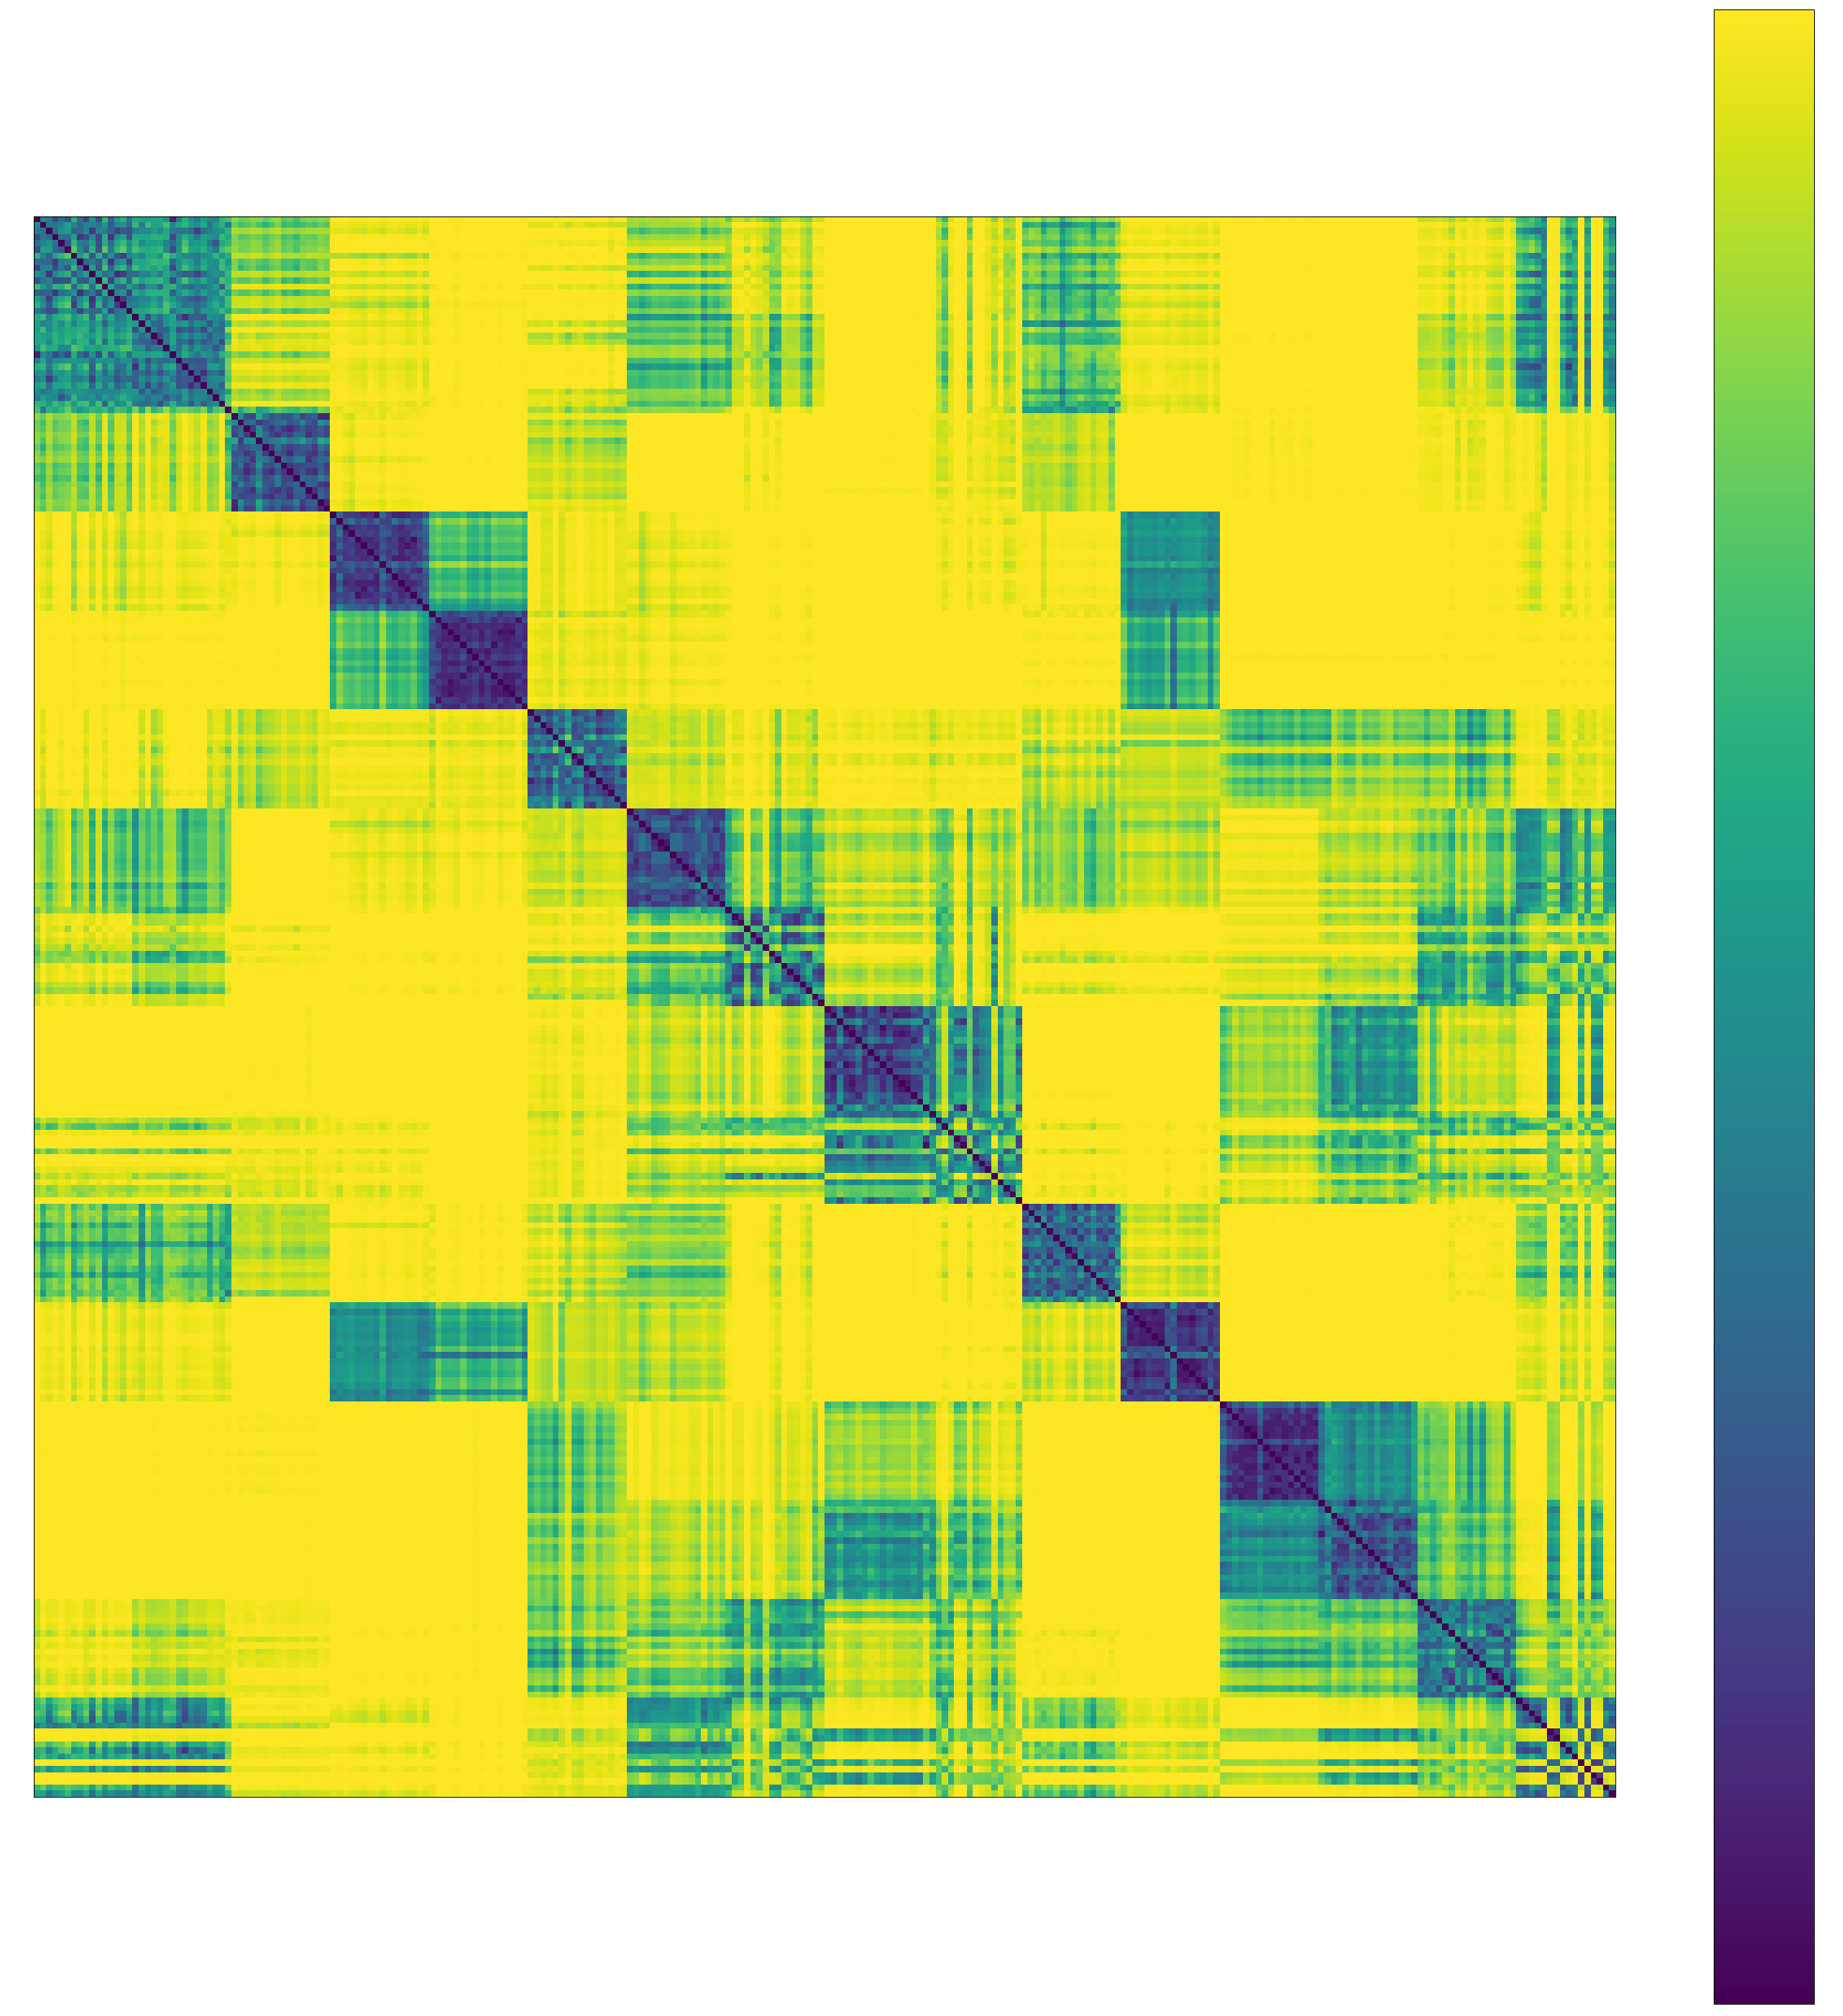

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(256, 256), dtype=float32)


In [8]:
from utils import plot_matrix
print(model)
samples = pd.DataFrame([train[i] for i in range(n_utterance ** 2)])

embeddings = model.embed(samples)
plot_matrix(model.distance(embeddings, embeddings, as_matrix = True, force_distance = False), norm = False)
print(embeddings)

## Tests

In [ ]:
from loggers import set_level
from utils import *

set_level('debug', 'datasets')
config = model.get_dataset_config(batch_size = n_utterance * 4, is_validation = False, shuffle_size = 0)
ds = prepare_dataset(train, ** config)

for inp, out in ds.take(5):
    for spect in inp:
        plot_spectrogram(spect)
    print(out)

test_dataset_time(ds, steps = 50)

In [ ]:
from utils import plot_spectrogram

for inp, out in ds.take(5):
    print(out)
    plot_spectrogram(** {'input {}'.format(i) : inp_i for i, inp_i in enumerate(inp)})

In [ ]:
from custom_train_objects.optimizers import WarmupScheduler

lr = WarmupScheduler(maxval = 1e-3, minval = 1e-4, factor = 256, warmup_steps = 4096)
lr.plot(25000)